### Load libraries

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
import wandb.sdk

In [2]:
sys.path.append("../..")
from src.utils import runs_to_df

### Load data

In [3]:
api = wandb.Api()
runs: list[wandb.sdk.wandb_run.Run] = api.runs(
    f"data-frugal-learning/adv-train",
    filters={"tags": {"$in": ["eps-ablation-v1", "try1.2", "try1.2.1", "try1.3", "try1.3.3"]}},
)

df = runs_to_df(runs)
df.loc[df.dataset.isna(), "dataset"] = "DatasetT.CIFAR5m"
df.loc[df.adv_eps_train.isna(), "adv_eps_train"] = 8/255

In [4]:
df.adv_eps_train.unique() * 255

array([10., 12.,  4., 16.,  6., 14.,  8.])

In [5]:
print(sorted(df.n_train.unique()))

[2, 4, 10, 20, 50, 80, 100, 200, 300, 500, 1000, 2000, 5000, 10000, 20000, 50000, 200000, 500000, 2000000, 5942688]


### Plots

In [6]:
COLORS = (
    "black",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
)

### Test error scaling

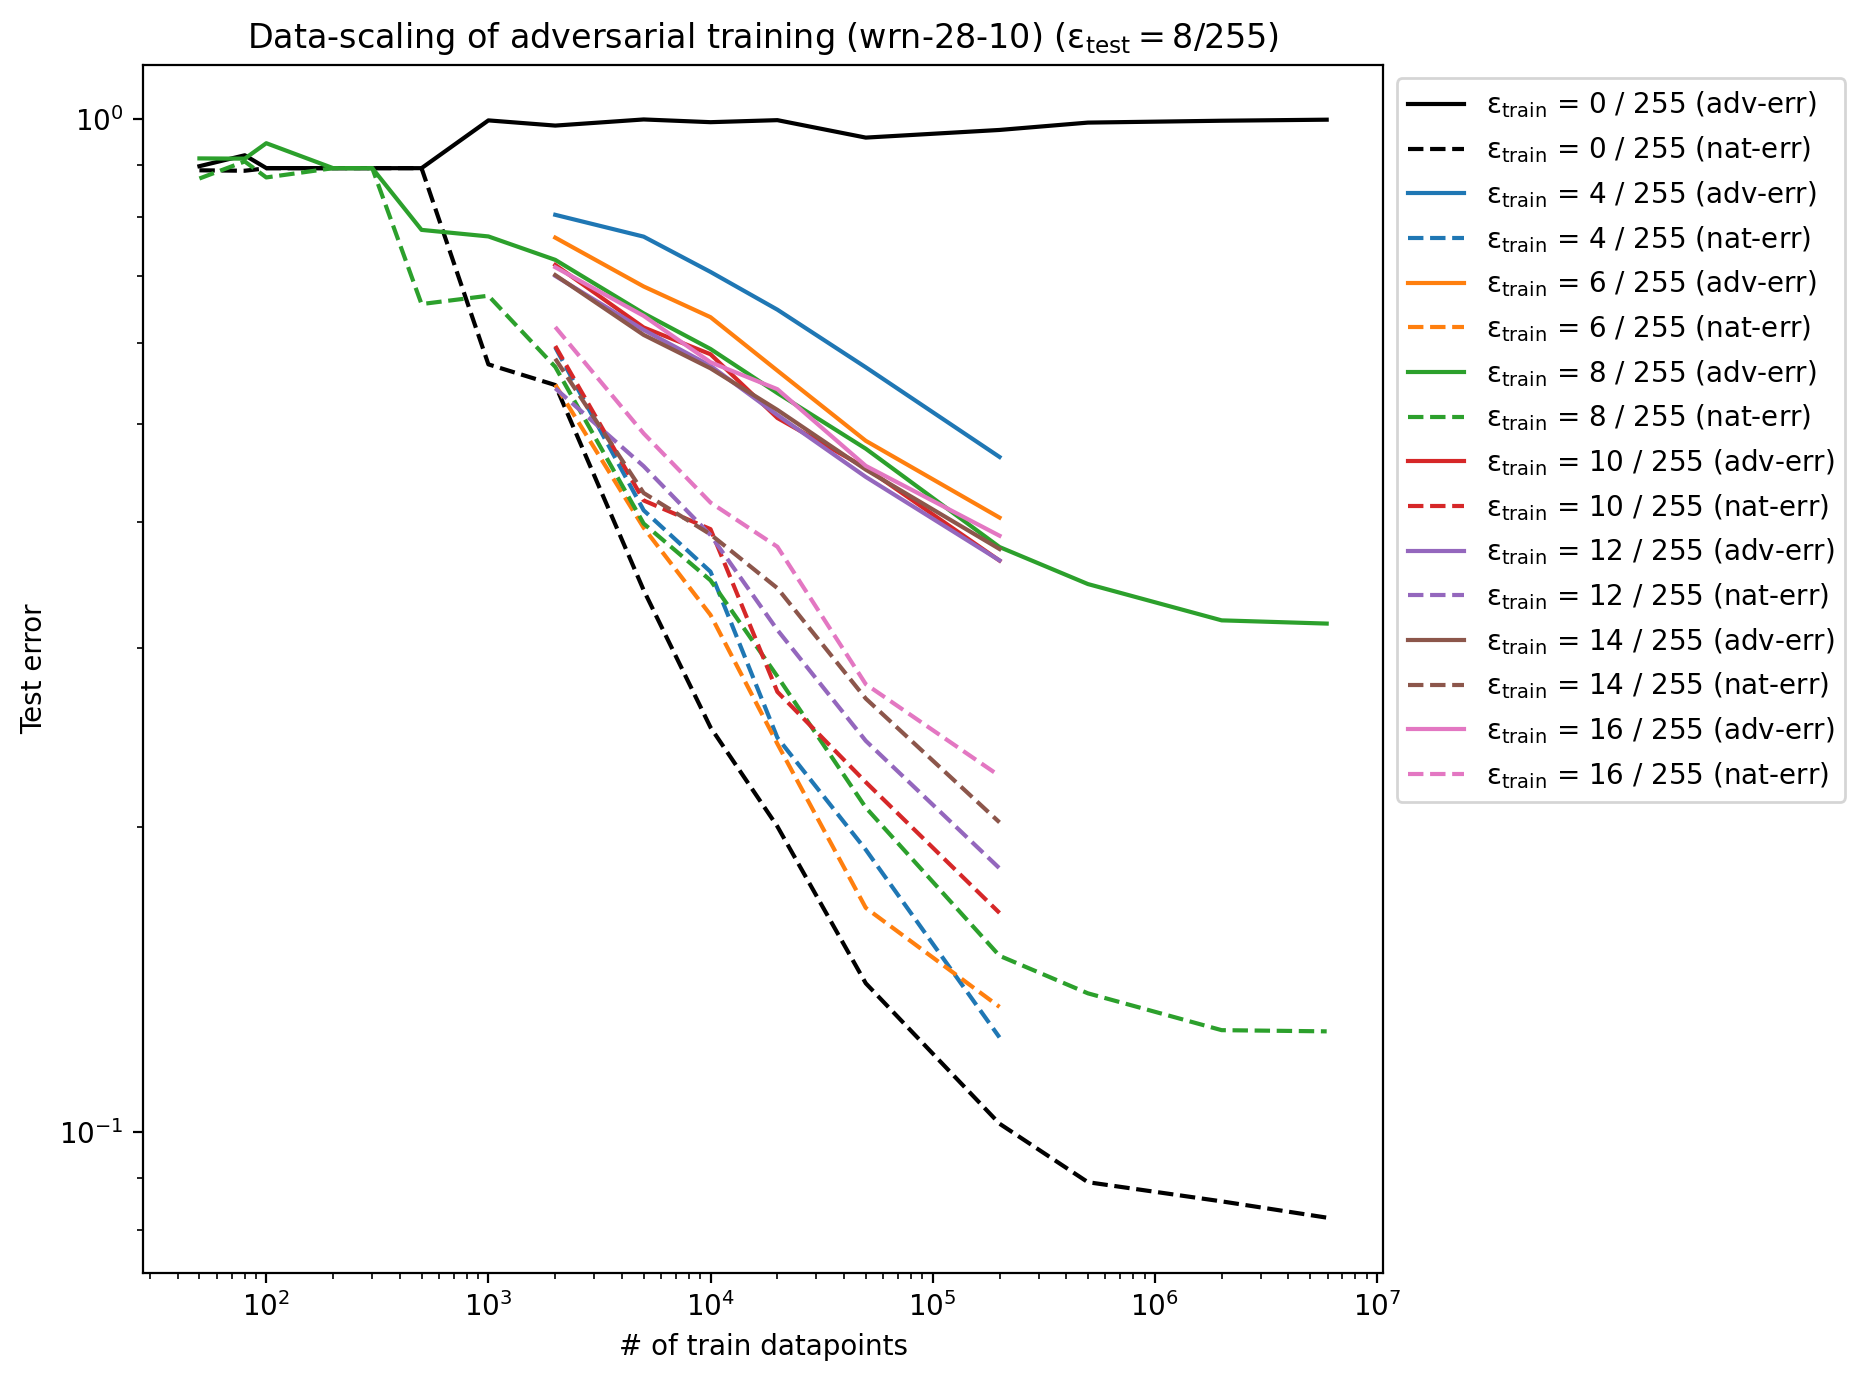

In [7]:
plt.figure(figsize=(8, 8), dpi=200)

for eps, color in zip([0] + list(sorted(df.adv_eps_train.unique())), COLORS):
    eps255 = round(eps * 255)

    if eps == 0:
        cdf = df[
            (df.width == 10) & (df.dataset == "DatasetT.CIFAR5m") & ~df.do_adv_training
        ].sort_values("n_train")
    else:
        cdf = df[
            (df.adv_eps_train == eps)
            & (df.width == 10)
            & (df.dataset == "DatasetT.CIFAR5m")
            & df.do_adv_training
        ].sort_values("n_train")

    plt.plot(
        cdf.n_train,
        1 - cdf.test_acc_adv,
        label=f"$\\mathrm{{\\epsilon}}_\\mathrm{{train}}$ = {eps255} / 255 (adv-err)",
        color=color,
    )

    plt.plot(
        cdf.n_train,
        1 - cdf.test_acc_nat,
        label=f"$\\mathrm{{\\epsilon}}_\\mathrm{{train}}$ = {eps255} / 255 (nat-err)",
        color=color,
        linestyle="--",
    )

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));
plt.xlabel("# of train datapoints")
plt.ylabel("Test error")
plt.title("Data-scaling of adversarial training (wrn-28-10) ($\\mathrm{{\\epsilon}}_\\mathrm{{test}} = 8 / 255$)");

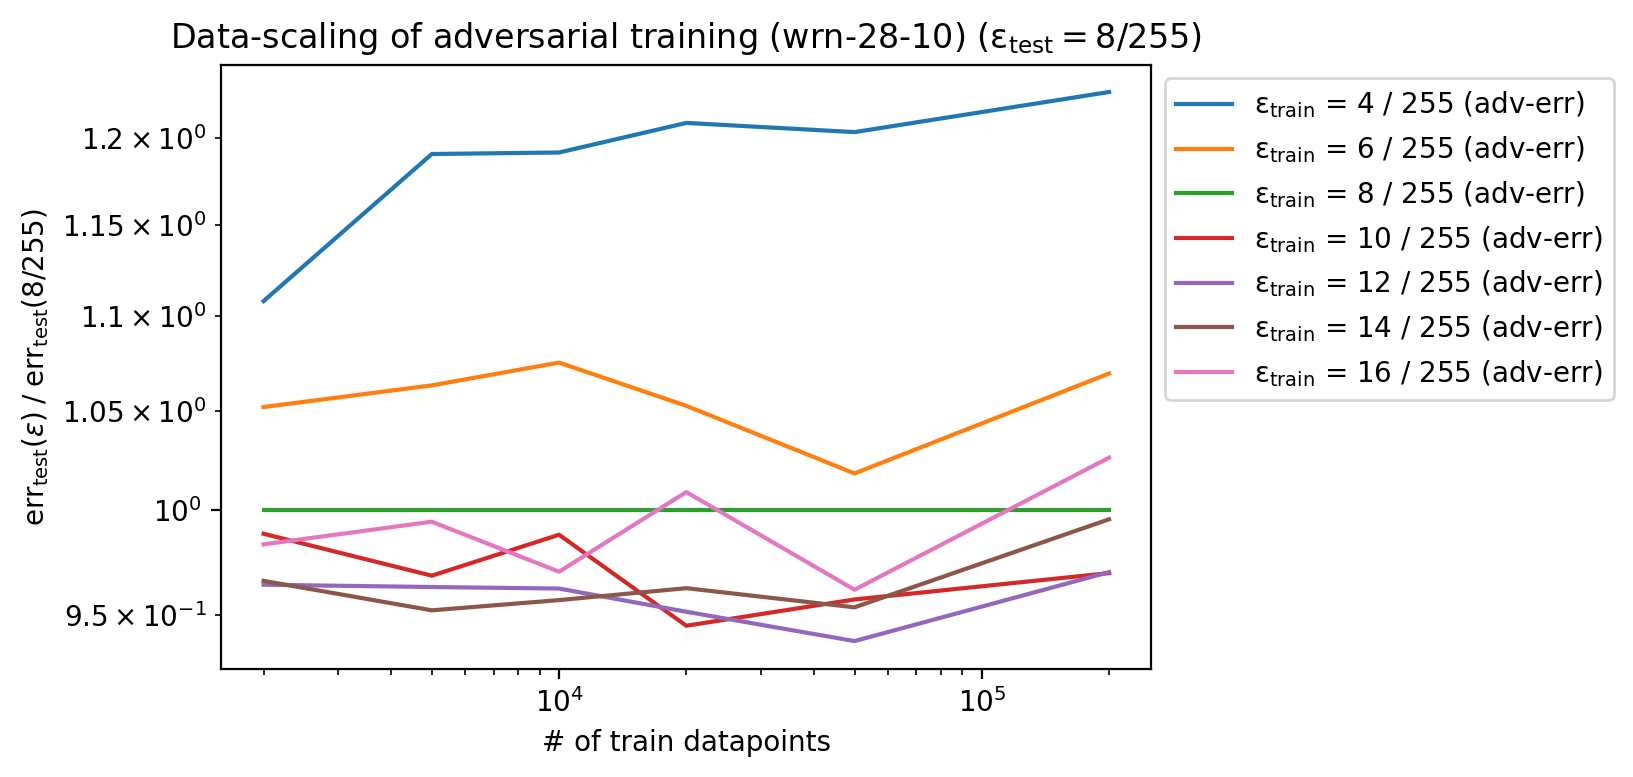

In [8]:
plt.figure(figsize=(6, 4), dpi=200)

base_df = df[
    (df.adv_eps_train == 8/255)
    & (df.width == 10)
    & (df.dataset == "DatasetT.CIFAR5m")
    & df.do_adv_training
].sort_values("n_train").reset_index().iloc[7:13].reset_index(drop=True)

for eps, color in zip(sorted(df.adv_eps_train.unique()), COLORS[1:]):
    eps255 = round(eps * 255)

    cdf = df[
        (df.adv_eps_train == eps)
        & (df.width == 10)
        & (df.dataset == "DatasetT.CIFAR5m")
        & df.do_adv_training
    ].sort_values("n_train").reset_index(drop=True)

    if eps255 == 8:
        cdf = cdf.iloc[7:13].reset_index(drop=True)

    assert(all(cdf.n_train == base_df.n_train))

    plt.plot(
        cdf.n_train,
        (1 - cdf.test_acc_adv) / (1 - base_df.test_acc_adv),
        label=f"$\\mathrm{{\\epsilon}}_\\mathrm{{train}}$ = {eps255} / 255 (adv-err)",
        color=color,
    )

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));
plt.xlabel("# of train datapoints")
plt.ylabel("$\\mathrm{err}_\\mathrm{test}(\\epsilon) \\; / \\; \\mathrm{err}_\\mathrm{test}(8 / 255)$")
plt.title("Data-scaling of adversarial training (wrn-28-10) ($\\mathrm{{\\epsilon}}_\\mathrm{{test}} = 8 / 255$)");

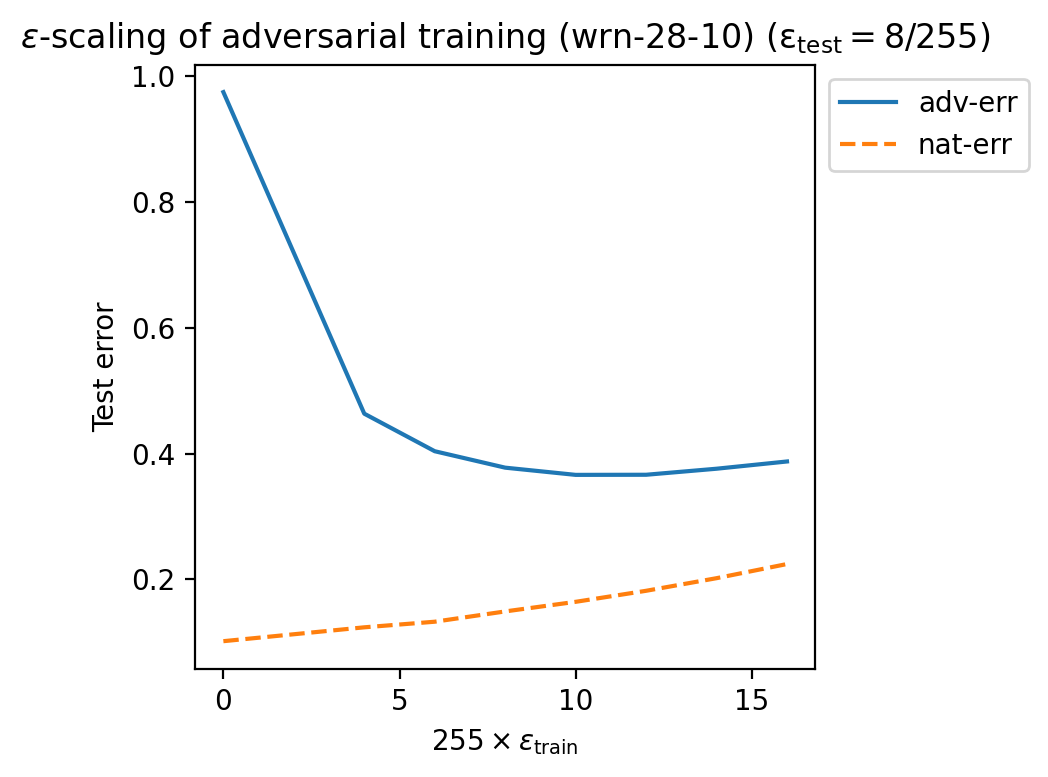

In [9]:
plt.figure(figsize=(4, 4), dpi=200)


def get_df(eps):
    return df[
        (
            (~df.do_adv_training)
            if eps == 0
            else ((df.adv_eps_train == eps) & df.do_adv_training)
        )
        & (df.width == 10)
        & (df.dataset == "DatasetT.CIFAR5m")
        & (df.n_train == 200_000)
    ]


eps_trains = np.array([0] + list(sorted(df.adv_eps_train.unique())))

plt.plot(
    255 * eps_trains, 1 - np.array([get_df(eps).test_acc_adv for eps in eps_trains]),
    label="adv-err"
)
plt.plot(
    255 * eps_trains, 1 - np.array([get_df(eps).test_acc_nat for eps in eps_trains]),
    label="nat-err", linestyle="--"
)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("$255 \\times \\epsilon_\\mathrm{train}$")
plt.ylabel("Test error")
plt.title("$\\epsilon$-scaling of adversarial training (wrn-28-10) ($\\mathrm{{\\epsilon}}_\\mathrm{{test}} = 8 / 255$)");

### Test loss

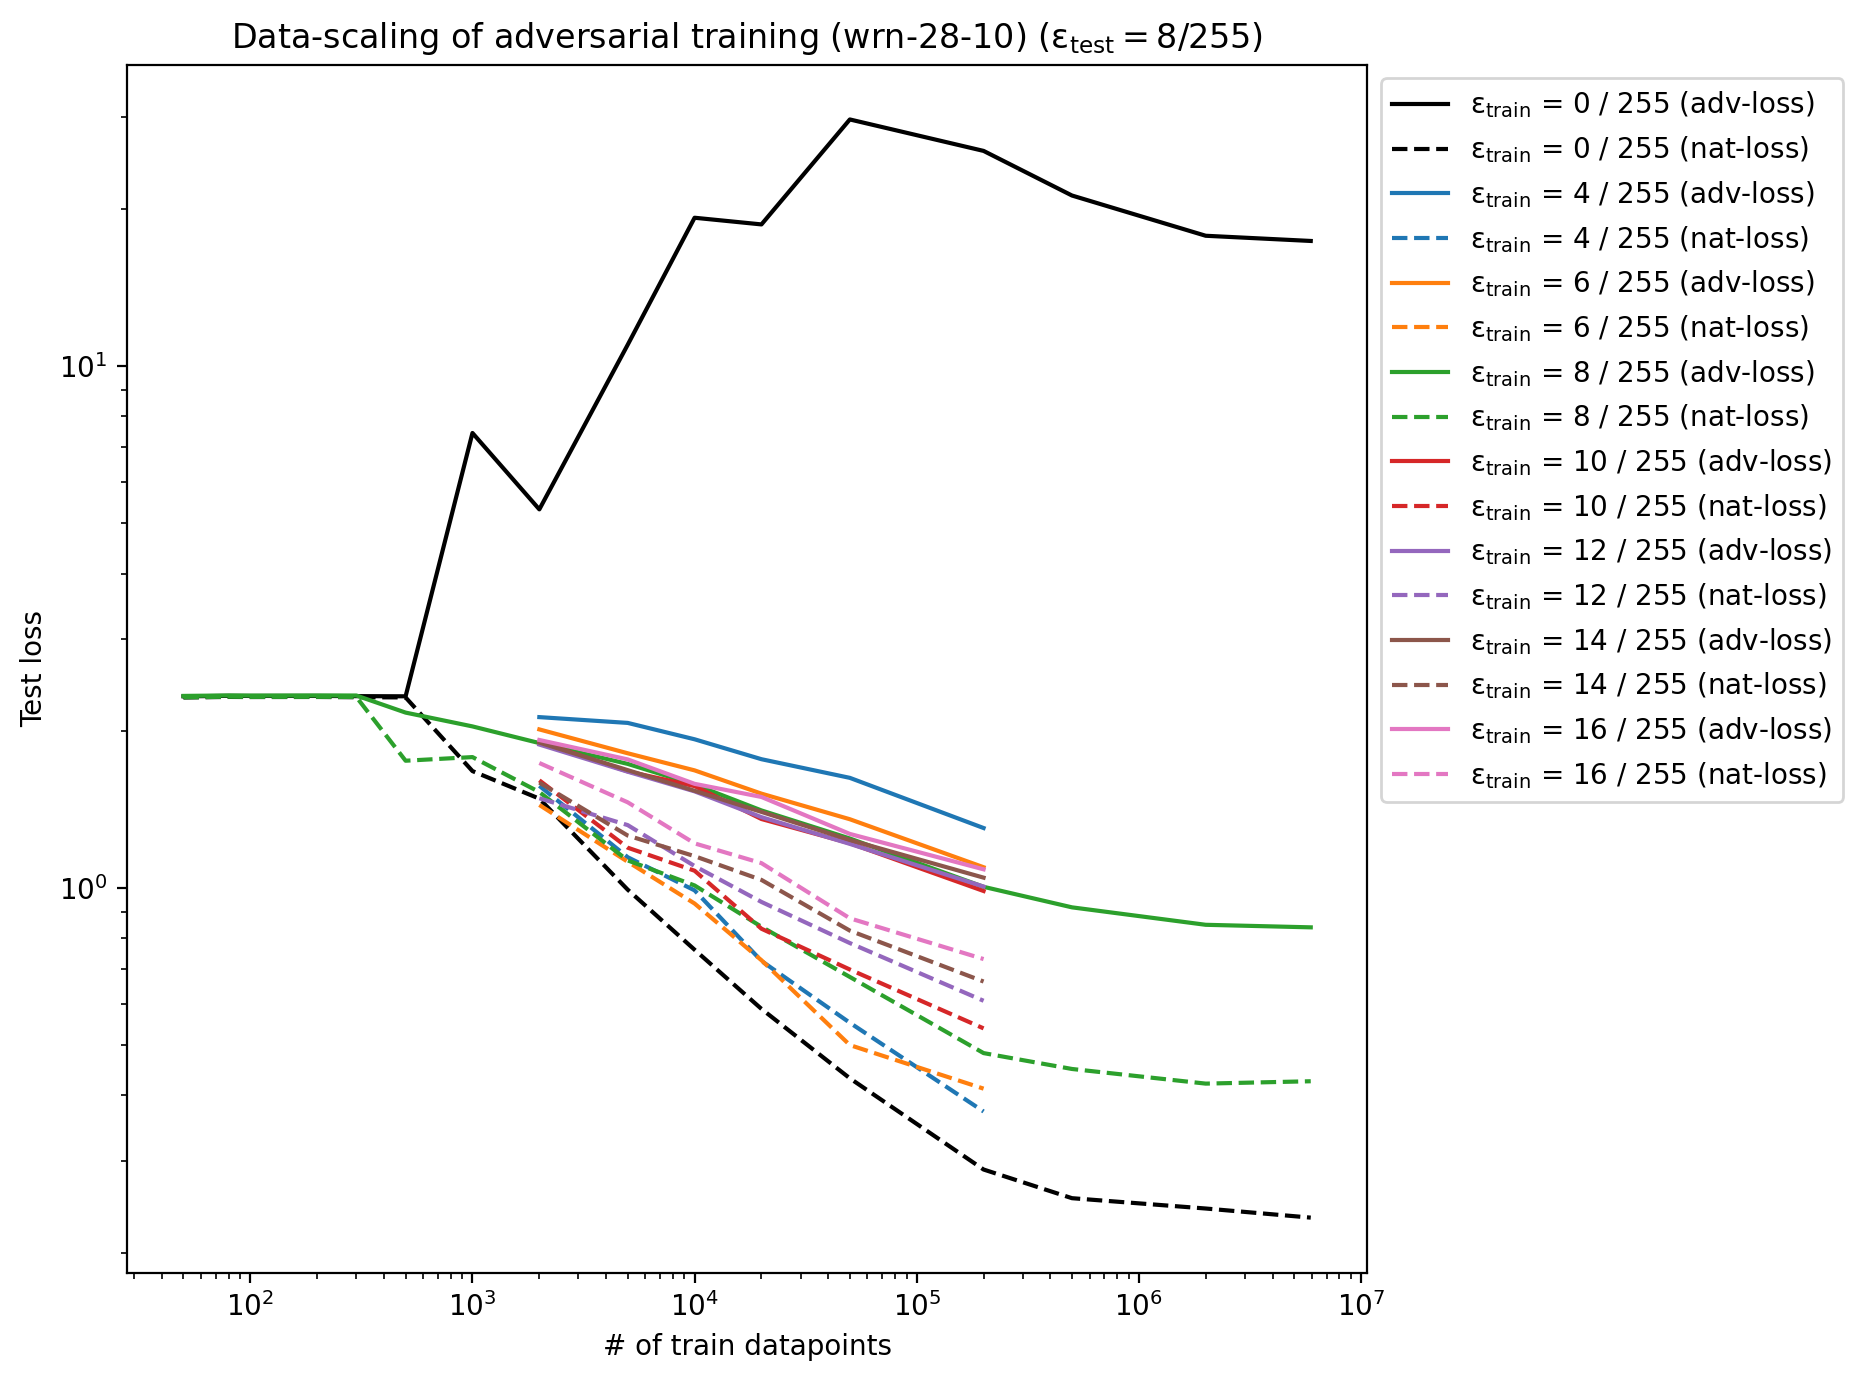

In [10]:
plt.figure(figsize=(8, 8), dpi=200)

for eps, color in zip([0] + list(sorted(df.adv_eps_train.unique())), COLORS):
    eps255 = round(eps * 255)

    if eps == 0:
        cdf = df[
            (df.width == 10) & (df.dataset == "DatasetT.CIFAR5m") & ~df.do_adv_training
        ].sort_values("n_train")
    else:
        cdf = df[
            (df.adv_eps_train == eps)
            & (df.width == 10)
            & (df.dataset == "DatasetT.CIFAR5m")
            & df.do_adv_training
        ].sort_values("n_train")

    plt.plot(
        cdf.n_train,
        cdf.test_loss_adv,
        label=f"$\\mathrm{{\\epsilon}}_\\mathrm{{train}}$ = {eps255} / 255 (adv-loss)",
        color=color,
    )

    plt.plot(
        cdf.n_train,
        cdf.test_loss_nat,
        label=f"$\\mathrm{{\\epsilon}}_\\mathrm{{train}}$ = {eps255} / 255 (nat-loss)",
        color=color,
        linestyle="--",
    )

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));
plt.xlabel("# of train datapoints")
plt.ylabel("Test loss")
plt.title("Data-scaling of adversarial training (wrn-28-10) ($\\mathrm{{\\epsilon}}_\\mathrm{{test}} = 8 / 255$)");

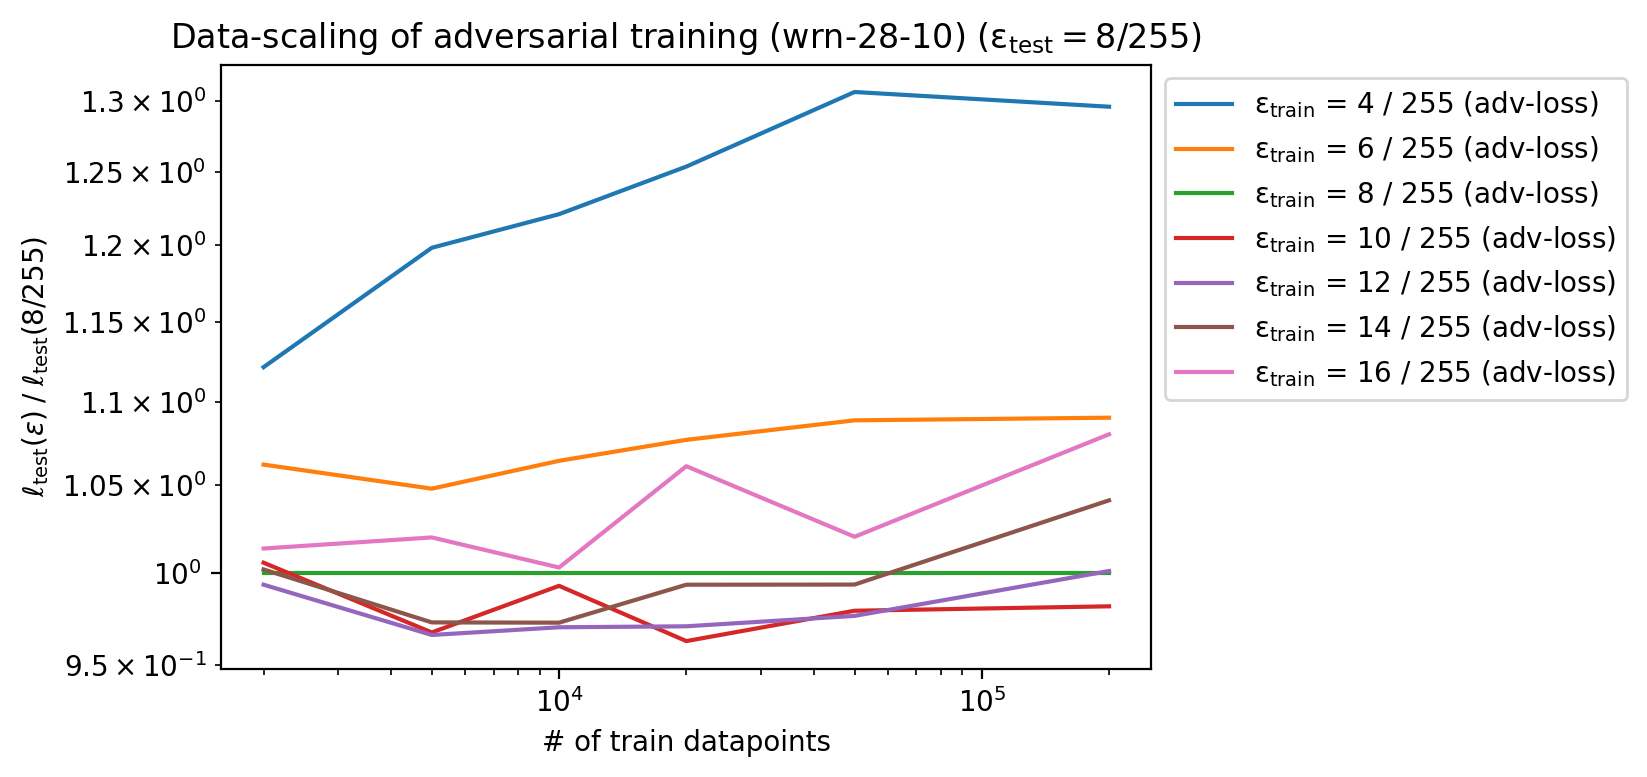

In [11]:
plt.figure(figsize=(6, 4), dpi=200)

base_df = df[
    (df.adv_eps_train == 8/255)
    & (df.width == 10)
    & (df.dataset == "DatasetT.CIFAR5m")
    & df.do_adv_training
].sort_values("n_train").reset_index().iloc[7:13].reset_index(drop=True)

for eps, color in zip(sorted(df.adv_eps_train.unique()), COLORS[1:]):
    eps255 = round(eps * 255)

    cdf = df[
        (df.adv_eps_train == eps)
        & (df.width == 10)
        & (df.dataset == "DatasetT.CIFAR5m")
        & df.do_adv_training
    ].sort_values("n_train").reset_index(drop=True)

    if eps255 == 8:
        cdf = cdf.iloc[7:13].reset_index(drop=True)

    assert(all(cdf.n_train == base_df.n_train))

    plt.plot(
        cdf.n_train,
        (cdf.test_loss_adv) / (base_df.test_loss_adv),
        label=f"$\\mathrm{{\\epsilon}}_\\mathrm{{train}}$ = {eps255} / 255 (adv-loss)",
        color=color,
    )

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));
plt.xlabel("# of train datapoints")
plt.ylabel("$\\mathrm{\\ell}_\\mathrm{test}(\\epsilon) \\; / \\; \\mathrm{\\ell}_\\mathrm{test}(8 / 255)$")
plt.title("Data-scaling of adversarial training (wrn-28-10) ($\\mathrm{{\\epsilon}}_\\mathrm{{test}} = 8 / 255$)");

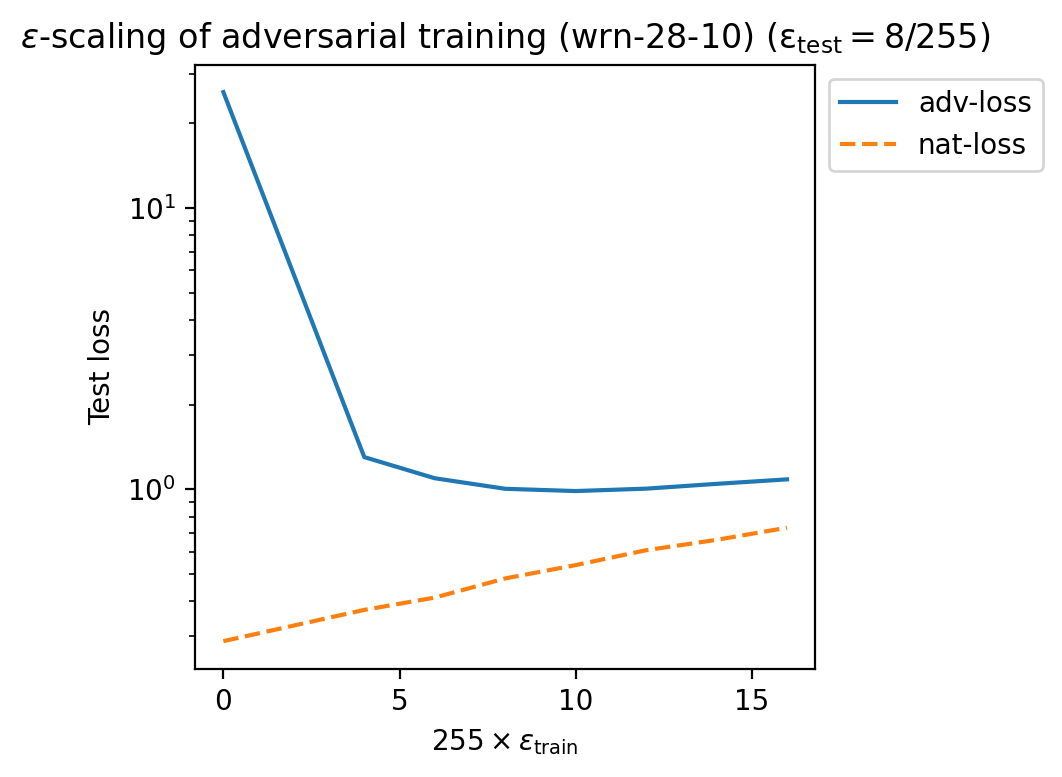

In [12]:
plt.figure(figsize=(4, 4), dpi=200)


def get_df(eps):
    return df[
        (
            (~df.do_adv_training)
            if eps == 0
            else ((df.adv_eps_train == eps) & df.do_adv_training)
        )
        & (df.width == 10)
        & (df.dataset == "DatasetT.CIFAR5m")
        & (df.n_train == 200_000)
    ]


eps_trains = np.array([0] + list(sorted(df.adv_eps_train.unique())))

plt.plot(
    255 * eps_trains, np.array([get_df(eps).test_loss_adv for eps in eps_trains]),
    label="adv-loss"
)
plt.plot(
    255 * eps_trains, np.array([get_df(eps).test_loss_nat for eps in eps_trains]),
    label="nat-loss", linestyle="--"
)

plt.yscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("$255 \\times \\epsilon_\\mathrm{train}$")
plt.ylabel("Test loss")
plt.title("$\\epsilon$-scaling of adversarial training (wrn-28-10) ($\\mathrm{{\\epsilon}}_\\mathrm{{test}} = 8 / 255$)");